# Project 4: Tree-Based Classification Models
#### For this project I will use the following tree-based classfication models to classify my dataset: Decision Tree, Bagging, Random Forest, Gradient Boost, Xtreme Gradient Boost, Light Gradient Boost, Ada Boost, and Cat Boost
#### I begin by importing all necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import graphviz
import timeit #imports timeit module
import pydotplus
import xgboost as xgb
import catboost as cb

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, accuracy_score, precision_score, auc, RocCurveDisplay, roc_auc_score, roc_curve
from sklearn import tree
from boruta import BorutaPy
from time import time


%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')



C:\Users\tsh3146\AppData\Local\Temp/ipykernel_28704/3543049056.py:36: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


#### Preview dataset

In [2]:
df = pd.read_csv('SRER_final_bi_v1.csv')
df.info()
print(df.head())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 41 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OID_          4339 non-null   int64  
 1   Id            4339 non-null   int64  
 2   gridcode      4339 non-null   int64  
 3   Shape_Length  4339 non-null   float64
 4   Shape_Area    4339 non-null   float64
 5   CH_min        4339 non-null   float64
 6   CH_max        4339 non-null   float64
 7   CH_mean       4339 non-null   float64
 8   CH_range      4339 non-null   float64
 9   CH_med        4339 non-null   float64
 10  CC_min        4339 non-null   float64
 11  CC_max        4339 non-null   float64
 12  CC_mean       4339 non-null   float64
 13  CC_range      4339 non-null   float64
 14  CC_med        4339 non-null   float64
 15  CD_min        4339 non-null   float64
 16  CD_max        4339 non-null   float64
 17  CD_mean       4339 non-null   float64
 18  CD_range      4339 non-null 

### Decision Tree Classifier

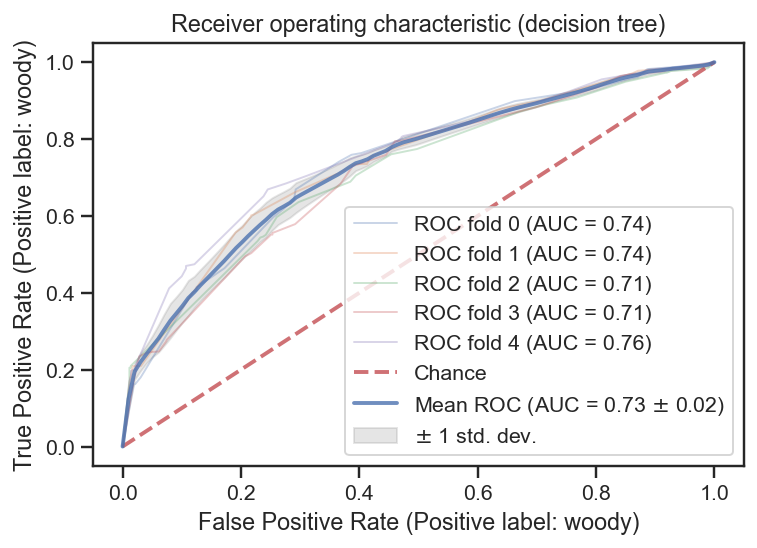

---Run time is 0.7808443000000125 seconds ---

Training Accuracy of each fold: 
 [0.7335061941803515, 0.7335061941803515, 0.7401325266493806, 0.7360991068856237, 0.7269585253456221]

Accuracy of each fold: 
 [0.6762672811059908, 0.6889400921658986, 0.6693548387096774, 0.6601382488479263, 0.7035755478662054]

Avg accuracy : 
0.6796552017391397

Std of accuracy : 
0.015211042594040805
              precision    recall  f1-score   support

   non-woody       0.65      0.71      0.68      2088
       woody       0.71      0.65      0.68      2251

    accuracy                           0.68      4339
   macro avg       0.68      0.68      0.68      4339
weighted avg       0.68      0.68      0.68      4339



True

In [4]:
kf = KFold(n_splits=5, random_state=42, shuffle=True) #initiate 5-fold cross, with shuffling and random state = 42
start_time = timeit.default_timer()

decision_tree = DecisionTreeClassifier(max_depth=6)

tprs = [];
aucs = [];
mean_fpr = np.linspace(0, 1, 100)

train_acc = [];
acc_score = [];
Truth = [];
output_pred = [];
output_ID = [];

fig, ax = plt.subplots()
    
for i, (train_index , test_index) in enumerate(kf.split(df)):
        #print(train_index); ## to check the training index
        #print(test_index); ## to check the testing index
        #print(); print();
    
        X_train , X_test, X_full = df.iloc[train_index, 5:-1], df.iloc[test_index, 5:-1], df.iloc[test_index, :-1]
        y_train , y_test = df.iloc[train_index,-1], df.iloc[test_index,-1]
        
        output_ID.append(X_full['Id'].tolist())
    
        #print([X_train.shape, y_train.shape]);
        #print([X_test.shape, y_test.shape]);
    
        decision_tree.fit(X_train,y_train)
        clf = decision_tree.fit(X_train,y_train)
        train_score = decision_tree.score(X_train, y_train)
        pred_values = decision_tree.predict(X_test)
        
        viz = RocCurveDisplay.from_estimator(
        decision_tree,
        X_test,
        y_test,
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        output_pred.append(pred_values.tolist())
        
        train_acc.append(train_score)
        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)
        
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic (decision tree)",
)
ax.legend(loc="lower right")
plt.show()

elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()
print('Training Accuracy of each fold: \n {}'.format(train_acc))
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

output_IDFlat = [item for sublist in output_ID for item in sublist]
output_predFlat = [item for sublist in output_pred for item in sublist]

predictionDF = pd.DataFrame(list(zip(output_IDFlat, output_predFlat)), columns = ['ID', 'Prediction'])
predictionDF.to_csv('decision_tree_pred.csv')

Truth = np.asarray(Truth)  ## or np.array(Truth)
Output = np.asarray(output_predFlat)

np.column_stack((Truth, Output))

print(classification_report(Truth, Output))

dot_data = export_graphviz(clf, out_file=None, 
                     feature_names=X_train.columns, 
                     class_names=y_train.name,
                     filled=True, rounded=True,  
                     special_characters=True)  
  

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('decision_tree.png')

### Bagging Classifier

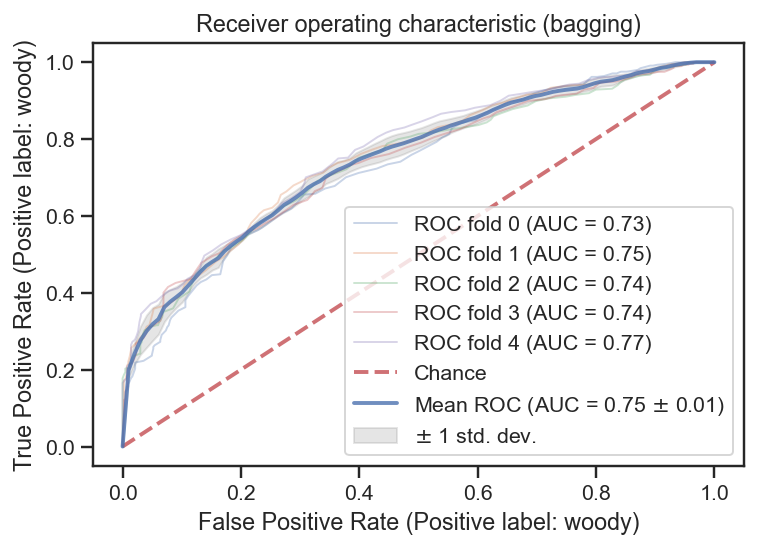

---Run time is 40.09413380000001 seconds ---

Training Accuracy of each fold: 
 [1.0, 1.0, 1.0, 1.0, 1.0]

Accuracy of each fold: 
 [0.6705069124423964, 0.6923963133640553, 0.6808755760368663, 0.6693548387096774, 0.6805074971164936]

Avg accuracy : 
0.6787282275338977

Std of accuracy : 
0.008367125145294207
              precision    recall  f1-score   support

   non-woody       0.66      0.70      0.68      2088
       woody       0.70      0.66      0.68      2251

    accuracy                           0.68      4339
   macro avg       0.68      0.68      0.68      4339
weighted avg       0.68      0.68      0.68      4339



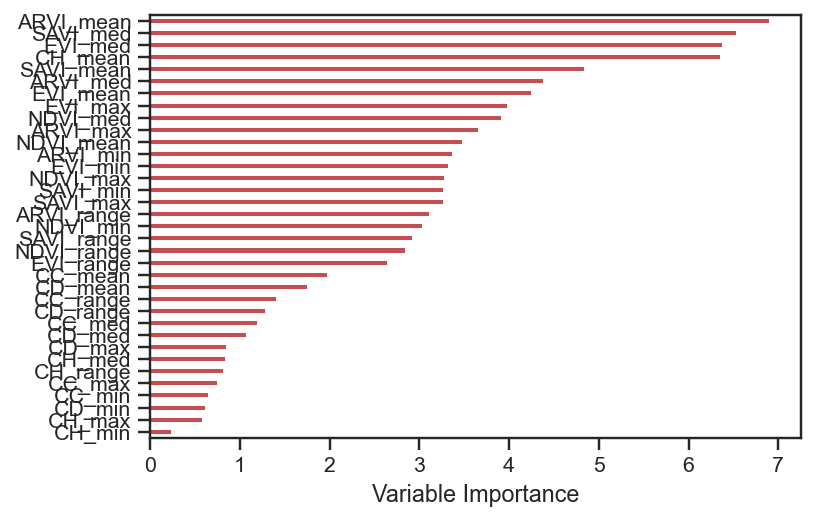

In [5]:
kf = KFold(n_splits=5, random_state=42, shuffle=True) #initiate 5-fold cross, with shuffling and random state = 42
start_time = timeit.default_timer()

bagging = RandomForestClassifier(max_features=35, random_state = 42)

tprs = [];
aucs = [];
mean_fpr = np.linspace(0, 1, 100)

train_acc = [];
acc_score = [];
Truth = [];
output_pred = [];
output_ID = [];

fig, ax = plt.subplots()

for i, (train_index , test_index) in enumerate(kf.split(df)):
        #print(train_index); ## to check the training index
        #print(test_index); ## to check the testing index
        #print(); print();
    
        X_train , X_test, X_full = df.iloc[train_index, 5:-1], df.iloc[test_index, 5:-1], df.iloc[test_index, :-1]
        y_train , y_test = df.iloc[train_index,-1], df.iloc[test_index,-1]
        
        output_ID.append(X_full['Id'].tolist())
    
        #print([X_train.shape, y_train.shape]);
        #print([X_test.shape, y_test.shape]);
    
        bagging.fit(X_train,y_train)
        clf = bagging.fit(X_train,y_train)
        train_score = bagging.score(X_train, y_train)
        pred_values = bagging.predict(X_test)
        
        viz = RocCurveDisplay.from_estimator(
        bagging,
        X_test,
        y_test,
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        output_pred.append(pred_values.tolist())
        
        train_acc.append(train_score)
        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)
        
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic (bagging)",
)
ax.legend(loc="lower right")
plt.show()

elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()
print('Training Accuracy of each fold: \n {}'.format(train_acc))
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

output_IDFlat = [item for sublist in output_ID for item in sublist]
output_predFlat = [item for sublist in output_pred for item in sublist]

predictionDF = pd.DataFrame(list(zip(output_IDFlat, output_predFlat)), columns = ['ID', 'Prediction'])
predictionDF.to_csv('bagging_pred.csv')

Truth = np.asarray(Truth)  ## or np.array(Truth)
Output = np.asarray(output_predFlat)

np.column_stack((Truth, Output))

print(classification_report(Truth, Output))

Importance = pd.DataFrame({'Importance':bagging.feature_importances_*100}, 
                          index = X_test.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None



### Random Forest Classifier

In [5]:
kf = KFold(n_splits=5, random_state=42, shuffle=True) #initiate 5-fold cross, with shuffling and random state = 42
start_time = timeit.default_timer()

random_forest = RandomForestClassifier(max_features=6, random_state = 42)

tprs = [];
aucs = [];
mean_fpr = np.linspace(0, 1, 100)

train_acc = [];
acc_score = [];
Truth = [];
output_pred = [];
output_ID = [];
    
for i, (train_index , test_index) in enumerate(kf.split(df)):
        #print(train_index); ## to check the training index
        #print(test_index); ## to check the testing index
        #print(); print();
    
        X_train , X_test, X_full = df.iloc[train_index, 5:-1], df.iloc[test_index, 5:-1], df.iloc[test_index, :-1]
        y_train , y_test = df.iloc[train_index,-1], df.iloc[test_index,-1]
        
        X_train_array = np.asarray(X_train)
        y_train_array = np.asarray(y_train)
        
        output_ID.append(X_full['Id'].tolist())
    
        #print([X_train.shape, y_train.shape]);
        #print([X_test.shape, y_test.shape]);
    
        random_forest.fit(X_train,y_train)
        clf = random_forest.fit(X_train,y_train)
        train_score = random_forest.score(X_train, y_train)
        pred_values = random_forest.predict(X_test)
        
        viz = RocCurveDisplay.from_estimator(
        random_forest,
        X_test,
        y_test,
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        output_pred.append(pred_values.tolist())
        
        train_acc.append(train_score)
        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)
        
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        
        feat_selector = BorutaPy(random_forest, n_estimators='auto', verbose=2, random_state=42)
        feat_selector.fit(X_train_array, y_train_array)
        
        feature_ranks = list(zip(df.iloc[train_index, 5:-1], 
                         feat_selector.ranking_, 
                         feat_selector.support_))
        
        for feat in feature_ranks:
            print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
            
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic (random forest)",
)
ax.legend(loc="lower right")
plt.show()  

elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()
print('Training Accuracy of each fold: \n {}'.format(train_acc))
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

output_IDFlat = [item for sublist in output_ID for item in sublist]
output_predFlat = [item for sublist in output_pred for item in sublist]

predictionDF = pd.DataFrame(list(zip(output_IDFlat, output_predFlat)), columns = ['ID', 'Prediction'])
predictionDF.to_csv('random_forest_pred.csv')

Truth = np.asarray(Truth)  ## or np.array(Truth)
Output = np.asarray(output_predFlat)

np.column_stack((Truth, Output))

print(classification_report(Truth, Output))

Importance = pd.DataFrame({'Importance':random_forest.feature_importances_*100}, 
                          index = X_test.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	18
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	18
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	18
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	18
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	18
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	18
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	18
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	5
Rejected: 	18
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	5
Reject

ValueError: Shape of passed values is (28, 1), indices imply (35, 1)

### Gradient Boost Classifier

---Run time is 110.03583870000011 seconds ---

Training Accuracy of each fold: 
 [0.7677902621722846, 0.7620282339383463, 0.7706712762892538, 0.7680783635839815, 0.7661290322580645]

Accuracy of each fold: 
 [0.6889400921658986, 0.7016129032258065, 0.6831797235023042, 0.7004608294930875, 0.7162629757785467]

Avg accuracy : 
0.6980913048331288

Std of accuracy : 
0.01143963179799665
              precision    recall  f1-score   support

   non-woody       0.68      0.71      0.69      2088
       woody       0.72      0.69      0.70      2251

    accuracy                           0.70      4339
   macro avg       0.70      0.70      0.70      4339
weighted avg       0.70      0.70      0.70      4339



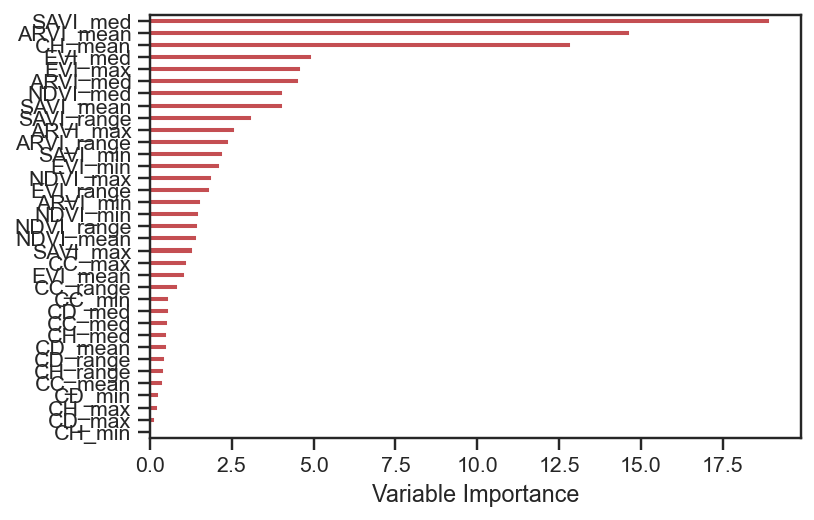

In [12]:
kf = KFold(n_splits=5, random_state=42, shuffle=True) #initiate 5-fold cross, with shuffling and random state = 42
start_time = timeit.default_timer()

gradient_boost = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.01, max_depth = 4, random_state = 42)

tprs = [];
aucs = [];
mean_fpr = np.linspace(0, 1, 100)

train_acc = [];
acc_score = [];
Truth = [];
output_pred = [];
output_ID = [];
    
for i, (train_index , test_index) in enumerate(kf.split(df)):
        #print(train_index); ## to check the training index
        #print(test_index); ## to check the testing index
        #print(); print();
    
        X_train , X_test, X_full = df.iloc[train_index, 5:-1], df.iloc[test_index, 5:-1], df.iloc[test_index, :-1]
        y_train , y_test = df.iloc[train_index,-1], df.iloc[test_index,-1]
        
        output_ID.append(X_full['Id'].tolist())
    
        #print([X_train.shape, y_train.shape]);
        #print([X_test.shape, y_test.shape]);
    
        gradient_boost.fit(X_train,y_train)
        clf = gradient_boost.fit(X_train,y_train)
        train_score = gradient_boost.score(X_train, y_train)
        pred_values = gradient_boost.predict(X_test)
        
        viz = RocCurveDisplay.from_estimator(
        gradient_boost,
        X_test,
        y_test,
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        output_pred.append(pred_values.tolist())
        
        train_acc.append(train_score)
        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)
        
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic (gradient boost)",
)
ax.legend(loc="lower right")
plt.show()        

elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()
print('Training Accuracy of each fold: \n {}'.format(train_acc))
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

output_IDFlat = [item for sublist in output_ID for item in sublist]
output_predFlat = [item for sublist in output_pred for item in sublist]

predictionDF = pd.DataFrame(list(zip(output_IDFlat, output_predFlat)), columns = ['ID', 'Prediction'])
predictionDF.to_csv('gradient_boost_pred.csv')

Truth = np.asarray(Truth)  ## or np.array(Truth)
Output = np.asarray(output_predFlat)

np.column_stack((Truth, Output))

print(classification_report(Truth, Output))

Importance = pd.DataFrame({'Importance':gradient_boost.feature_importances_*100}, 
                          index = X_test.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None


### Xtreme Gradient Boost Classifier

---Run time is 13.002664999999979 seconds ---

Training Accuracy of each fold: 
 [0.7441659464131374, 0.7392682224142898, 0.7435897435897436, 0.7395563238259868, 0.7347350230414746]

Accuracy of each fold: 
 [0.6889400921658986, 0.6993087557603687, 0.6808755760368663, 0.6900921658986175, 0.7185697808535179]

Avg accuracy : 
0.6955572741430538

Std of accuracy : 
0.012906245342063093
              precision    recall  f1-score   support

   non-woody       0.67      0.72      0.69      2088
       woody       0.72      0.68      0.70      2251

    accuracy                           0.70      4339
   macro avg       0.70      0.70      0.70      4339
weighted avg       0.70      0.70      0.70      4339



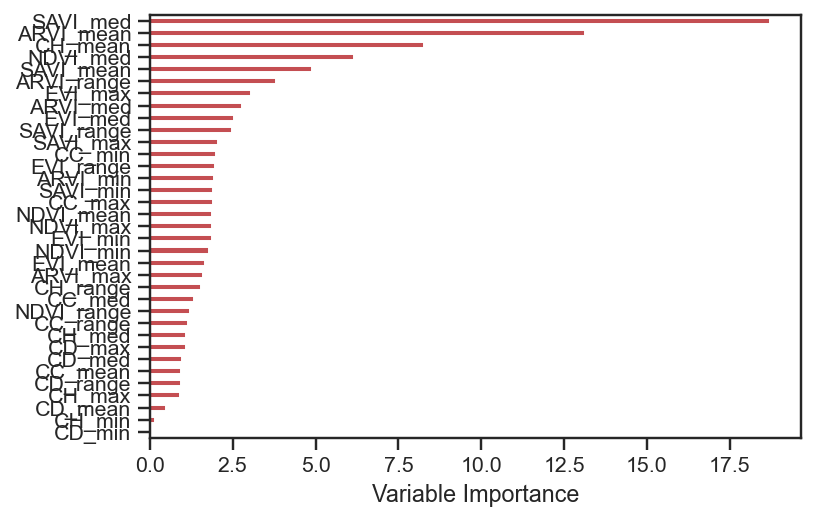

In [40]:
kf = KFold(n_splits=5, random_state=42, shuffle=True) #initiate 5-fold cross, with shuffling and random state = 42
start_time = timeit.default_timer()

XGB = XGBClassifier(n_estimators = 500, learning_rate = 0.01, use_label_encoder = True, verbose = None, max_depth = 4, eval_metric = 'logloss', random_state = 42)

train_acc = [];
acc_score = [];
Truth = [];
output_pred = [];
output_ID = [];
    
for train_index , test_index in kf.split(df):
        #print(train_index); ## to check the training index
        #print(test_index); ## to check the testing index
        #print(); print();
    
        X_train , X_test, X_full = df.iloc[train_index, 5:-1], df.iloc[test_index, 5:-1], df.iloc[test_index, :-1]
        y_train , y_test = df.iloc[train_index,-1], df.iloc[test_index,-1]
        
        output_ID.append(X_full['Id'].tolist())
    
        #print([X_train.shape, y_train.shape]);
        #print([X_test.shape, y_test.shape]);
    
        XGB.fit(X_train,y_train)
        clf = XGB.fit(X_train,y_train)
        train_score = XGB.score(X_train, y_train)
        pred_values = XGB.predict(X_test)
        
        output_pred.append(pred_values.tolist())
        
        train_acc.append(train_score)
        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)
        
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()
print('Training Accuracy of each fold: \n {}'.format(train_acc))
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

output_IDFlat = [item for sublist in output_ID for item in sublist]
output_predFlat = [item for sublist in output_pred for item in sublist]

predictionDF = pd.DataFrame(list(zip(output_IDFlat, output_predFlat)), columns = ['ID', 'Prediction'])
predictionDF.to_csv('XGB_pred.csv')

Truth = np.asarray(Truth)  ## or np.array(Truth)
Output = np.asarray(output_predFlat)

np.column_stack((Truth, Output))

print(classification_report(Truth, Output))

Importance = pd.DataFrame({'Importance':XGB.feature_importances_*100}, 
                          index = X_test.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### Light Gradient Boost Classifier

---Run time is 2.0965130000004137 seconds ---

Training Accuracy of each fold: 
 [0.7458945548833189, 0.7381158167675022, 0.7427254393546528, 0.738403918179199, 0.7399193548387096]

Accuracy of each fold: 
 [0.6900921658986175, 0.6900921658986175, 0.6889400921658986, 0.6993087557603687, 0.7139561707035755]

Avg accuracy : 
0.6964778700854156

Std of accuracy : 
0.009506602317231567
              precision    recall  f1-score   support

   non-woody       0.67      0.72      0.69      2088
       woody       0.72      0.68      0.70      2251

    accuracy                           0.70      4339
   macro avg       0.70      0.70      0.70      4339
weighted avg       0.70      0.70      0.70      4339



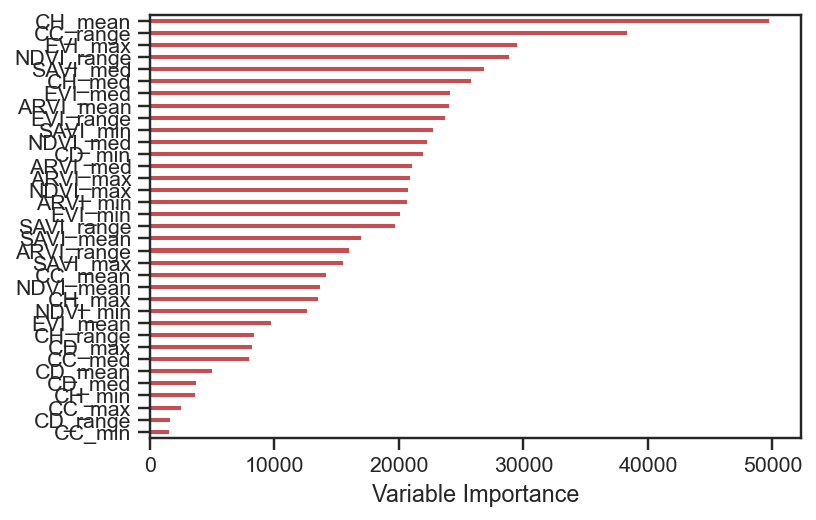

In [41]:
kf = KFold(n_splits=5, random_state=42, shuffle=True) #initiate 5-fold cross, with shuffling and random state = 42
start_time = timeit.default_timer()

LGB = LGBMClassifier(n_estimators = 500, learning_rate = 0.01, max_depth = 4, random_state = 42)

train_acc = [];
acc_score = [];
Truth = [];
output_pred = [];
output_ID = [];
    
for train_index , test_index in kf.split(df):
        #print(train_index); ## to check the training index
        #print(test_index); ## to check the testing index
        #print(); print();
    
        X_train , X_test, X_full = df.iloc[train_index, 5:-1], df.iloc[test_index, 5:-1], df.iloc[test_index, :-1]
        y_train , y_test = df.iloc[train_index,-1], df.iloc[test_index,-1]
        
        output_ID.append(X_full['Id'].tolist())
    
        #print([X_train.shape, y_train.shape]);
        #print([X_test.shape, y_test.shape]);
    
        LGB.fit(X_train,y_train)
        clf = LGB.fit(X_train,y_train)
        train_score = LGB.score(X_train, y_train)
        pred_values = LGB.predict(X_test)
        
        output_pred.append(pred_values.tolist())
        
        train_acc.append(train_score)
        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)
        
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()
print('Training Accuracy of each fold: \n {}'.format(train_acc))
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

output_IDFlat = [item for sublist in output_ID for item in sublist]
output_predFlat = [item for sublist in output_pred for item in sublist]

predictionDF = pd.DataFrame(list(zip(output_IDFlat, output_predFlat)), columns = ['ID', 'Prediction'])
predictionDF.to_csv('LGB_pred.csv')

Truth = np.asarray(Truth)  ## or np.array(Truth)
Output = np.asarray(output_predFlat)

np.column_stack((Truth, Output))

print(classification_report(Truth, Output))

Importance = pd.DataFrame({'Importance':LGB.feature_importances_*100}, 
                          index = X_test.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### Ada Boost Classifier

---Run time is 46.31767589999981 seconds ---

Training Accuracy of each fold: 
 [0.7021031403053875, 0.6949006050129646, 0.6983578219533275, 0.6960530106597522, 0.6923963133640553]

Accuracy of each fold: 
 [0.6670506912442397, 0.6877880184331797, 0.6774193548387096, 0.6970046082949308, 0.7093425605536332]

Avg accuracy : 
0.6877210466729385

Std of accuracy : 
0.014744947014453662
              precision    recall  f1-score   support

   non-woody       0.67      0.68      0.68      2088
       woody       0.70      0.69      0.70      2251

    accuracy                           0.69      4339
   macro avg       0.69      0.69      0.69      4339
weighted avg       0.69      0.69      0.69      4339



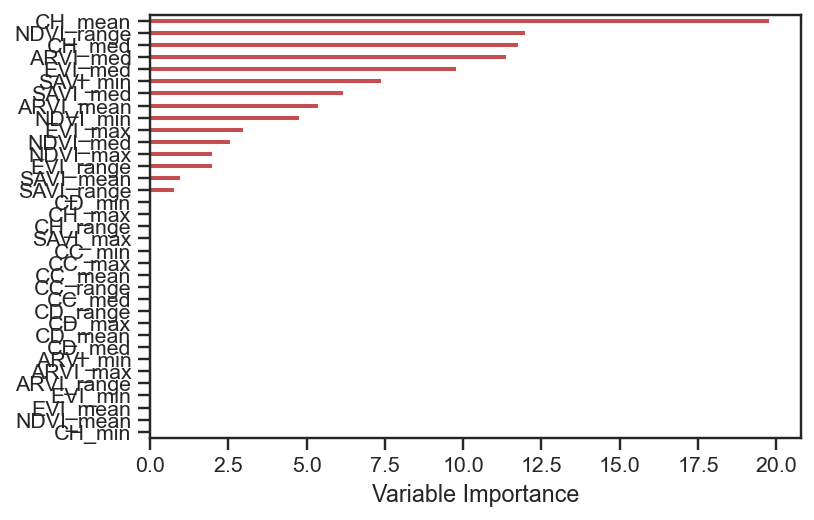

In [43]:
kf = KFold(n_splits=5, random_state=42, shuffle=True) #initiate 5-fold cross, with shuffling and random state = 42
start_time = timeit.default_timer()

ADA = AdaBoostClassifier(n_estimators = 500, learning_rate = 0.01, algorithm="SAMME.R", random_state = 42)

train_acc = [];
acc_score = [];
Truth = [];
output_pred = [];
output_ID = [];
    
for train_index , test_index in kf.split(df):
        #print(train_index); ## to check the training index
        #print(test_index); ## to check the testing index
        #print(); print();
    
        X_train , X_test, X_full = df.iloc[train_index, 5:-1], df.iloc[test_index, 5:-1], df.iloc[test_index, :-1]
        y_train , y_test = df.iloc[train_index,-1], df.iloc[test_index,-1]
        
        output_ID.append(X_full['Id'].tolist())
    
        #print([X_train.shape, y_train.shape]);
        #print([X_test.shape, y_test.shape]);
    
        ADA.fit(X_train,y_train)
        clf = ADA.fit(X_train,y_train)
        train_score = ADA.score(X_train, y_train)
        pred_values = ADA.predict(X_test)
        
        output_pred.append(pred_values.tolist())
        
        train_acc.append(train_score)
        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)
        
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()
print('Training Accuracy of each fold: \n {}'.format(train_acc))
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

output_IDFlat = [item for sublist in output_ID for item in sublist]
output_predFlat = [item for sublist in output_pred for item in sublist]

predictionDF = pd.DataFrame(list(zip(output_IDFlat, output_predFlat)), columns = ['ID', 'Prediction'])
predictionDF.to_csv('ADA_pred.csv')

Truth = np.asarray(Truth)  ## or np.array(Truth)
Output = np.asarray(output_predFlat)

np.column_stack((Truth, Output))

print(classification_report(Truth, Output))

Importance = pd.DataFrame({'Importance':ADA.feature_importances_*100}, 
                          index = X_test.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### Cat Boost Classifier

0:	learn: 0.6902239	total: 142ms	remaining: 1m 10s
1:	learn: 0.6873372	total: 146ms	remaining: 36.3s
2:	learn: 0.6852547	total: 150ms	remaining: 24.8s
3:	learn: 0.6834099	total: 153ms	remaining: 19s
4:	learn: 0.6813740	total: 156ms	remaining: 15.5s
5:	learn: 0.6797851	total: 159ms	remaining: 13.1s
6:	learn: 0.6777985	total: 161ms	remaining: 11.3s
7:	learn: 0.6759666	total: 163ms	remaining: 10s
8:	learn: 0.6739601	total: 165ms	remaining: 9.02s
9:	learn: 0.6713983	total: 167ms	remaining: 8.2s
10:	learn: 0.6697805	total: 169ms	remaining: 7.51s
11:	learn: 0.6677081	total: 171ms	remaining: 6.93s
12:	learn: 0.6662707	total: 172ms	remaining: 6.45s
13:	learn: 0.6644944	total: 174ms	remaining: 6.03s
14:	learn: 0.6621876	total: 175ms	remaining: 5.66s
15:	learn: 0.6604651	total: 176ms	remaining: 5.33s
16:	learn: 0.6585823	total: 178ms	remaining: 5.05s
17:	learn: 0.6563868	total: 179ms	remaining: 4.8s
18:	learn: 0.6540600	total: 181ms	remaining: 4.58s
19:	learn: 0.6523811	total: 182ms	remaining: 4

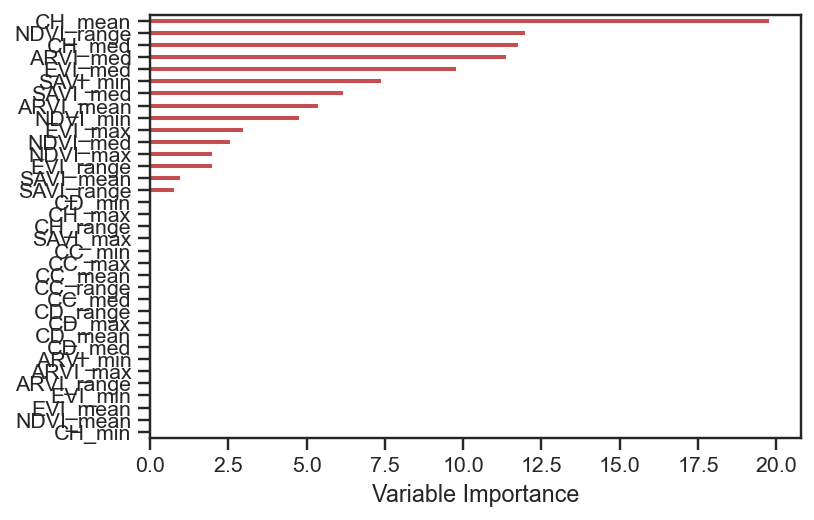

In [47]:
kf = KFold(n_splits=5, random_state=42, shuffle=True) #initiate 5-fold cross, with shuffling and random state = 42
start_time = timeit.default_timer()

catboost = CatBoostClassifier(iterations = 500, depth = 4, learning_rate = 0.01, loss_function = 'Logloss', random_state = 42)

train_acc = [];
acc_score = [];
Truth = [];
output_pred = [];
output_ID = [];
    
for train_index , test_index in kf.split(df):
        #print(train_index); ## to check the training index
        #print(test_index); ## to check the testing index
        #print(); print();
    
        X_train , X_test, X_full = df.iloc[train_index, 5:-1], df.iloc[test_index, 5:-1], df.iloc[test_index, :-1]
        y_train , y_test = df.iloc[train_index,-1], df.iloc[test_index,-1]
        
        output_ID.append(X_full['Id'].tolist())
    
        #print([X_train.shape, y_train.shape]);
        #print([X_test.shape, y_test.shape]);
    
        catboost.fit(X_train,y_train)
        clf = catboost.fit(X_train,y_train)
        train_score = catboost.score(X_train, y_train)
        pred_values = catboost.predict(X_test)
        
        output_pred.append(pred_values.tolist())
        
        train_acc.append(train_score)
        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)
        
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()
print('Training Accuracy of each fold: \n {}'.format(train_acc))
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

output_IDFlat = [item for sublist in output_ID for item in sublist]
output_predFlat = [item for sublist in output_pred for item in sublist]

predictionDF = pd.DataFrame(list(zip(output_IDFlat, output_predFlat)), columns = ['ID', 'Prediction'])
predictionDF.to_csv('catboost_pred.csv')

Truth = np.asarray(Truth)  ## or np.array(Truth)
Output = np.asarray(output_predFlat)

np.column_stack((Truth, Output))

print(classification_report(Truth, Output))

Importance = pd.DataFrame({'Importance':ADA.feature_importances_*100}, 
                          index = X_test.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None